# Packages import

In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gstools as gs
from gstools import Krige
import geopandas as gpd
from pykrige.ok import OrdinaryKriging

# Create data & transform in dataframe

In [13]:
# --- 1. Pr√©paration des donn√©es ---
data = {
    "Station": [f"S{i+1}" for i in range(15)],
    "Longitude": [16.0, 15.5, 16.0, 13.5, 14.0, 14.0, 15.2, 15.5, 17.2, 12.0, 16.8, 13, 16.1, 17.4, 16.6],
    "Latitude":  [-4.0, -3.1, -5.1, -1.0, -3.1, -6.0, -4.7, -3.1, -2.2, -2.0, -4.2, -4.4, -5.4, -6.4, -3.5],
    "Temperature": [28.5, 27.0, 26.2, 22.5, 24.8, 24.2, 28.1, 26.5, 21.1, 19.2, 25.8, 27.5, 26.0, 24.5, 25.9]
}
df = pd.DataFrame(data)

# Extraction et pr√©paration des donn√©es pour GSTools

In [14]:
# Les coordonn√©es doivent √™tre sous la forme (2, N_points) pour gstools, d'o√π le .T (transpos√©e)
coords = df[['Longitude', 'Latitude']].values.T
temp = df['Temperature'].values

In [15]:
print(f"- coords = {coords}\n\n- temperature = {temp}")

- coords = [[16.  15.5 16.  13.5 14.  14.  15.2 15.5 17.2 12.  16.8 13.  16.1 17.4
  16.6]
 [-4.  -3.1 -5.1 -1.  -3.1 -6.  -4.7 -3.1 -2.2 -2.  -4.2 -4.4 -5.4 -6.4
  -3.5]]

- temperature = [28.5 27.  26.2 22.5 24.8 24.2 28.1 26.5 21.1 19.2 25.8 27.5 26.  24.5
 25.9]


In [17]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
print(df)

   Station  Longitude  Latitude  Temperature
0       S1       16.0      -4.0         28.5
1       S2       15.5      -3.1         27.0
2       S3       16.0      -5.1         26.2
3       S4       13.5      -1.0         22.5
4       S5       14.0      -3.1         24.8
5       S6       14.0      -6.0         24.2
6       S7       15.2      -4.7         28.1
7       S8       15.5      -3.1         26.5
8       S9       17.2      -2.2         21.1
9      S10       12.0      -2.0         19.2
10     S11       16.8      -4.2         25.8
11     S12       13.0      -4.4         27.5
12     S13       16.1      -5.4         26.0
13     S14       17.4      -6.4         24.5
14     S15       16.6      -3.5         25.9


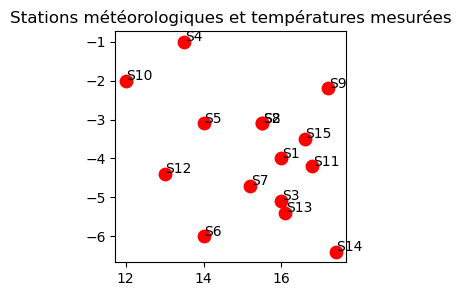

In [18]:
# Visualisation des points
fig, ax = plt.subplots(figsize=(6,3))

gdf.plot(ax=ax, color="red", markersize=80)
for x, y, label in zip(df.Longitude, df.Latitude, df.Station):
    ax.text(x+0.02, y+0.02, label, fontsize=10)
    
plt.title("Stations m√©t√©orologiques et temp√©ratures mesur√©es")
plt.show()

# --- 2. Estimation du Variogramme Exp√©rimental ---

## cr√©er des intervalles de classes de distance

In [19]:
# Cr√©e les classes de distance (lags) de 0 √† 6 (distance max entre 2 lieux cf. dataset), en 10 intervalles.
# par convention, we choose between 10 & 20 intervals
bins = np.linspace(0, 7, 10) # np.linspace(min, max, number)

## calcul proprement-dit de la semi-variance

In [20]:
# Calcule la semi-variance pour chaque classe de distance
#bin_center = moiti√© de la classe bin (valeur ayant servie pour le calcul de gamma (semi-variogramme))
bin_center, gamma = gs.vario_estimate(coords, temp, bins)

In [21]:
print(f"- bin_center : \n{bin_center} \n\n- gamma : \n{gamma}")

- bin_center : 
[0.38888889 1.16666667 1.94444444 2.72222222 3.5        4.27777778
 5.05555556 5.83333333 6.61111111] 

- gamma : 
[ 0.05        2.2675      4.95392857  4.83147059  8.05277778 16.335
 11.49125     0.          8.0225    ]


# grille d'interpolation

In [57]:
gridx = np.linspace(df.Longitude.min(), df.Longitude.max(), 50)
gridy = np.linspace(df.Latitude.min(), df.Latitude.max(), 50)

# models

## ajustement de multiples mod√®les

In [22]:
# --- 3. Ajustement de multiples mod√®les et s√©lection ---

# D√©finit les mod√®les th√©oriques de variogramme qui seront test√©s.
models_test = {
    "Spherical": gs.Spherical,
    "Exponential": gs.Exponential,
    "Gaussian": gs.Gaussian,
    "Linear": gs.Linear,
    "Matern": gs.Matern,
}

In [23]:
models_test

{'Spherical': gstools.covmodel.models.Spherical,
 'Exponential': gstools.covmodel.models.Exponential,
 'Gaussian': gstools.covmodel.models.Gaussian,
 'Linear': gstools.covmodel.models.Linear,
 'Matern': gstools.covmodel.models.Matern}

In [24]:
# dictionnary on python : dict = {key : value}
scores = {} # va contenir le score r2
fitted_models = {} # va contenir les resulytats du mod√®le entra√Æn√©
print("--- R√©sultats de l'Ajustement des Mod√®les ---")

#key = model_name; value = model_class
#models_test{model_name : model_class} avec models_test.items() = valeurs du dictionnaire models_test
for model_name, model_class in models_test.items():
    # Initialise l'objet mod√®le th√©orique
    fit_model = model_class(dim=2) # consid√©rant les donn√©es sur 2D cf. coords
    
    # Tente d'ajuster le mod√®le th√©orique aux points du variogramme exp√©rimental.
    # return_r2 = True retourne le score de Pseudo-R2 pour √©valuer l'ajustement.
    try:
        para, pcov, r2 = fit_model.fit_variogram(
            bin_center,
            gamma,
            return_r2=True,
        )
        fitted_models[model_name] = fit_model
        scores[model_name] = r2
        print(f"Mod√®le {model_name:<12}: R2 = {r2:.4f} | Param√®tres: {fit_model}")
    except RuntimeError:
        scores[model_name] = -np.inf
        print(f"Mod√®le {model_name:<12}: AJUSTEMENT √âCHOU√â")

--- R√©sultats de l'Ajustement des Mod√®les ---
Mod√®le Spherical   : R2 = 0.3511 | Param√®tres: Spherical(dim=2, var=8.68, len_scale=5.09, nugget=1.29e-08)
Mod√®le Exponential : R2 = 0.2852 | Param√®tres: Exponential(dim=2, var=9.72, len_scale=2.87)
Mod√®le Gaussian    : R2 = 0.3566 | Param√®tres: Gaussian(dim=2, var=8.7, len_scale=1.99)


C:\Users\Lenovo\anaconda3\Lib\site-packages\gstools\covmodel\tools.py:552: AttributeWarning: Dimension 2 is not appropriate for this model.
  warnings.warn(


Mod√®le Linear      : R2 = 0.3752 | Param√®tres: Linear(dim=2, var=9.29, len_scale=4.28, nugget=0.0667)
Mod√®le Matern      : R2 = 0.3566 | Param√®tres: Matern(dim=2, var=8.7, len_scale=1.12, nugget=8.65e-07, nu=24.6)


## selection du best model

In [25]:
# Classement des mod√®les par score R2 d√©croissant (du meilleur au pire ajustement).
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
best_model_name, best_r2 = ranking[0]
best_model = fitted_models[best_model_name] # R√©cup√®re le mod√®le th√©orique le mieux ajust√©.

print(f"\n‚úÖ **Meilleur Mod√®le S√©lectionn√© : {best_model_name} (R2: {best_r2:.4f})**")


‚úÖ **Meilleur Mod√®le S√©lectionn√© : Linear (R2: 0.3752)**


# visualisation de l'ajustement

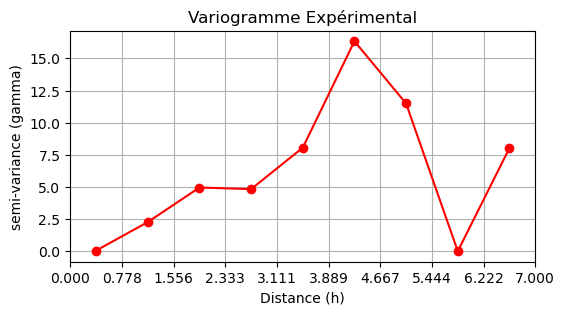

In [26]:
# --- 4. Visualisation de l'ajustement (Optionnel) ---
plt.figure(figsize=(6, 3))
# Affiche les points du variogramme exp√©rimental.
plt.plot(bin_center, gamma, color="red", marker='o')
ax = plt.gca()
plt.title("Variogramme Exp√©rimental")
plt.xlabel("Distance (h)")
plt.xticks(bins)
plt.ylabel("semi-variance (gamma)")
plt.grid()

# afficher tous les mod√®les ajust√©s pour comparaison

C:\Users\Lenovo\anaconda3\Lib\site-packages\gstools\covmodel\plot.py:134: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_108228\3993939459.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend() # L'avertissement de l√©gende est masqu√© par le filtre


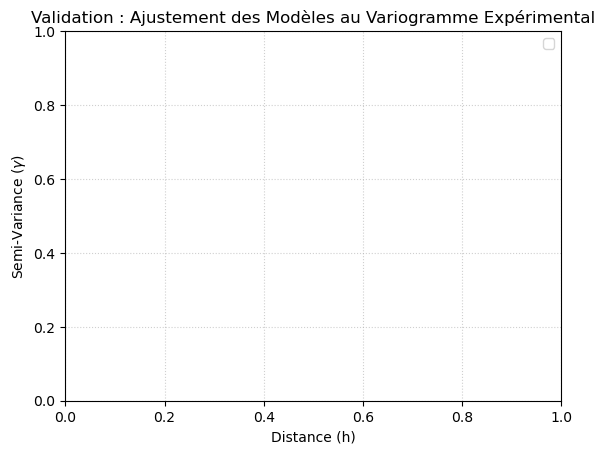

In [27]:
# Affiche tous les mod√®les ajust√©s pour comparaison.
for model_name, model in fitted_models.items():
    if model_name == best_model_name:
        model.plot(ax=ax, label=f"{model_name} (BEST)", color='red', linestyle='-', linewidth=3)
    elif scores[model_name] > 0:
        model.plot(ax=ax, label=model_name, linestyle='--', linewidth=1, alpha=0.7)

plt.title("Validation : Ajustement des Mod√®les au Variogramme Exp√©rimental")
plt.xlabel("Distance (h)")
plt.ylabel(r"Semi-Variance ($\gamma$)") 
plt.legend() # L'avertissement de l√©gende est masqu√© par le filtre
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Kriging of best model

In [58]:
# --- 5. Krigeage Ordinaire avec le meilleur mod√®le ---

# D√©finition de la grille de pr√©diction (coordonn√©es des points √† interpoler)
min_lon, max_lon = 11, 18
min_lat, max_lat = -7, 0

lon_pred = np.linspace(min_lon, max_lon, 50)
lat_pred = np.linspace(min_lat, max_lat, 50)
grid = np.meshgrid(lon_pred, lat_pred)

In [59]:
# Formate les coordonn√©es de la grille pour le krigeage (2, N_points_grille)
kriging_coords = np.vstack([arr.flatten() for arr in grid])

In [60]:
print(coords.shape)
print(len(temp))
print(np.isnan(coords).sum(), np.isnan(temp).sum())

(2, 15)
15
0 0


In [61]:
# transpos√© coords (2, 15) √† (15, 2)
coords2 = coords.T
print(coords2.shape)

(15, 2)


In [62]:


# Initialise la m√©thode de Krigeage Ordinaire en utilisant le meilleur mod√®le.
ok = OrdinaryKriging(
    x=coords2[:, 0],
    y=coords2[:, 1],
    z=temp,
    variogram_model=best_model
)

In [74]:
# Ex√©cute l'interpolation. kriging_map est l'estimation, kriging_var est l'incertitude.
print("\nEx√©cution du Krigeage Ordinaire...")
kriging_map, kriging_var = ok.execute("grid", gridx, gridy)


Ex√©cution du Krigeage Ordinaire...


In [75]:
# Remet la carte d'estimation √† sa forme de grille 2D (50x50) pour l'affichage.
kriging_map = kriging_map.reshape((50, 50))

## --- 6. Visualisation des r√©sultats du Krigeage (Optionnel) ---

## visualisation : method 1

(10.928571428571429,
 18.07142857142857,
 -7.071428571428571,
 0.07142857142857162)

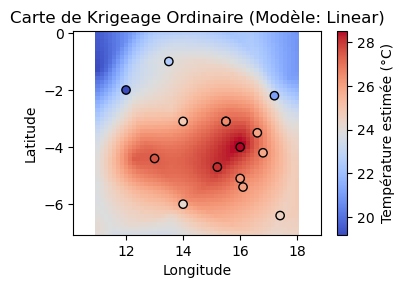

In [113]:
plt.figure(figsize=(4, 9))
# Sous-figure 1: Carte d'estimation (Temp√©rature)
plt.subplot(3, 1, 1)
# Utilise pcolormesh pour tracer la carte d'estimation
plt.pcolormesh(lon_pred, lat_pred, kriging_map,
               cmap="coolwarm")
# Ajoute les points de donn√©es originaux pour r√©f√©rence
# plt.scatter(s=l, edgecolors=b) avec l repr√©sentant la taille des cercles
                            # b la couleur du contour des points
plt.scatter(df['Longitude'], df['Latitude'],
            c=df['Temperature'], cmap='coolwarm',
            edgecolors='black', label='Donn√©es')
plt.colorbar(label="Temp√©rature estim√©e (¬∞C)")
plt.title(f"Carte de Krigeage Ordinaire (Mod√®le: {best_model_name})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')

# visualisation : method 2

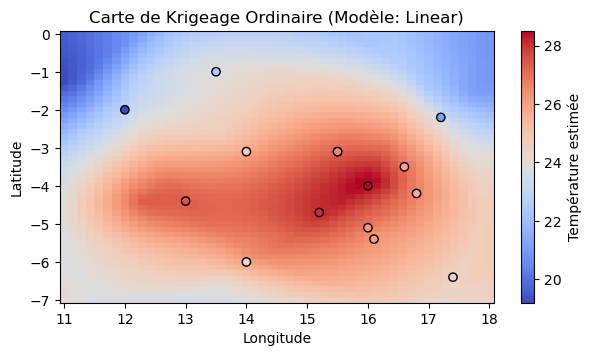

In [119]:
lon_mesh, lat_mesh = np.meshgrid(lon_pred, lat_pred)
plt.figure(figsize=(7, 12))
plt.subplot(3, 1, 2)
# üîß ICI la cl√© : lon_mesh et lat_mesh sont 2D, comme kriging_map
plt.pcolormesh(lon_mesh, lat_mesh, kriging_map,
               cmap="coolwarm")

plt.scatter(df['Longitude'], df['Latitude'],
            c=df['Temperature'], cmap='coolwarm',
            edgecolors='black', label='Donn√©es')

plt.title(f"Carte de Krigeage Ordinaire (Mod√®le: {best_model_name})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Temp√©rature estim√©e")

# visualisation : method 3 (lisse)

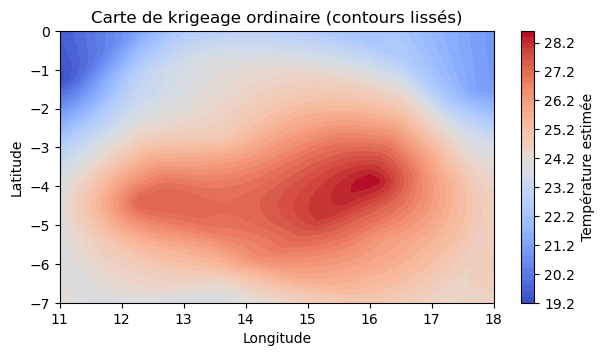

In [134]:
plt.figure(figsize=(7, 12))
plt.subplot(3, 1, 3)
plt.contourf(lon_mesh, lat_mesh, kriging_map, levels=50, cmap="coolwarm")
#plt.scatter(df['Longitude'], df['Latitude'], c=df['Temperature'],
           # cmap='coolwarm', edgecolors='black', s=40)
plt.title("Carte de krigeage ordinaire (contours liss√©s)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Temp√©rature estim√©e")

plt.show()

# Carte d'incertitude

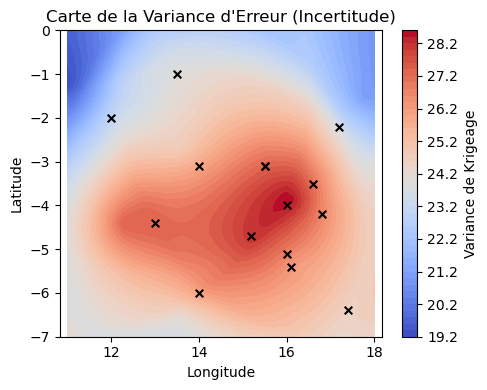

In [135]:
# --- 6. Visualisation des r√©sultats du Krigeage (Optionnel) ---
plt.figure(figsize=(5, 4))

# Trace la carte de la variance de krigeage, repr√©sentant l'incertitude de l'estimation
cf = plt.contourf(lon_mesh, lat_mesh, kriging_map, levels=50, cmap="coolwarm")
plt.scatter(df['Longitude'], df['Latitude'],
            c='black', marker='x', s=30, label='Stations')

# Colorbar associ√©e √† contourf
cbar = plt.colorbar(cf)
cbar.set_label("Variance de Krigeage")

plt.title("Carte de la Variance d'Erreur (Incertitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')

plt.tight_layout()
plt.show()